In [1]:
from read_dag import read_dag
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pydot

In [116]:
class Task:
    def __init__(self, id):
        self.id = id
        self.pid = None
        self.rank = None
        self.AFT = 0
        self.scheduled = False
        self.complete = False

class Processor:
    def __init__(self, id):
        self.id = id
        self.task_list = []
        self.time_avail = 0

    def add_task(self, task, min_EFT):
        print(f"Scheduling task {task.id} on processor {self.id}")
        self.task_list.append(task.id)
        task.AFT = min_EFT
        self.time_avail = min_EFT
        return

class AEFT:
    def __init__(self, input_list=None, file=None, verbose=False, p=3, b=0.5, ccr=0.5):
        if input_list is None and file is not None:
            self.num_tasks, self.num_processors, self.comp_cost, self.graph = read_dag(file, p, b, ccr)
        elif len(input_list) == 4 and file is None:
            self.num_tasks, self.num_processors, self.comp_cost, self.graph = input_list
        else:
            print('Enter filename or input params')
            raise Exception()

        self.dependency_mx = np.logical_not(self.graph > -1)
        self.ioct_mx = self.calculate_IOCT()
        self.tasks = {i:Task(i) for i in range(self.num_tasks)}
        self.task_schedule = [self.tasks[0]]
        self.tasks[0].scheduled = True
        self.processors = {i:Processor(i) for i in range(self.num_processors)}
        self.calculate_rank()

    # Tasks are organized along the rows, processors are organized along the columns
    def calculate_IOCT(self):
        ioct_mx = np.copy(self.comp_cost)
        last_node = self.num_tasks - 1
        indices = np.where(self.graph != -1)  # indices[0] is row index of entries != -1, indices[1] is col index of entries != -1
    
        for node_index in range(last_node - 1, -1, -1):
            mask = indices[0] == node_index
            masked_idxs = (indices[0][mask], indices[1][mask])
            succ_ioct = ioct_mx[masked_idxs[1]]  # successor computational costs
    
            if succ_ioct.size == 0:
                continue
    
            min_arrs = []
            for proc in range(self.num_processors):
                comm_cost = self.graph[masked_idxs][:, np.newaxis].repeat(self.num_processors, axis=1)
                comm_cost[:, proc] = 0
                temp_ioct = comm_cost + succ_ioct
                min_ioct = np.min(temp_ioct, axis=1) # minimize along the processor axis
                min_arrs.append(min_ioct)
    
            min_arrs = np.column_stack(min_arrs)
            max_arr = np.max(min_arrs, axis=0) # maximize over the successor axis
            ioct_mx[node_index] += max_arr
    
        return ioct_mx
    
    def calculate_rank(self):
        rank_mx = np.mean(self.ioct_mx, axis=1)
        rank_dict = {}
        for idx, rank in enumerate(rank_mx):
            self.tasks[idx].rank = rank
        return

    def run_schedule(self):
        while len(self.task_schedule) > 0:
            task = self.get_highest_rank_task()
            # Get predecessors
            indices = np.where(aeft.graph != -1)
            mask = indices[1] == task.id
            masked_idxs = (indices[0][mask], indices[1][mask])
            EFT_dict = {}
            IEFT_dict = {}
            for pid, proc in self.processors.items():
                # Check for start node
                if len(masked_idxs[0]) == 0:
                        max_aft = 0
                else:
                    # Calculate AFT for predecessor tasks
                    aft_arr = np.zeros(len(masked_idxs[0]))
                    comm_cost = self.graph[masked_idxs]
                    pred_tasks = [self.tasks[idx] for idx in masked_idxs[0]]
                    for i, pred_task in enumerate(pred_tasks):
                        # Include communication cost if we need to transfer data
                        if pred_task.pid != pid:
                            aft_arr[i] += pred_task.AFT + comm_cost[i]
                        else:
                            aft_arr[i] += pred_task.AFT
                    max_aft = np.max(aft_arr)
                EST = max([proc.time_avail, max_aft])
                EFT = EST + self.comp_cost[task.id, pid]
                IEFT = EFT + self.ioct_mx[task.id, pid]
                EFT_dict[pid] = EFT
                IEFT_dict[pid] = IEFT
            outd = np.count_nonzero(self.graph[task.id] > -1)
            if outd > self.num_processors:
                min_EFT = float('inf')
                best_pid = None
                for pid, EFT in EFT_dict.items():
                    if EFT < min_EFT:
                        best_pid = pid
                        min_EFT = EFT
                print(f"(EFT) Task {task.id}: best pid={best_pid}")
                if best_pid is not None:
                    self.processors[best_pid].add_task(task, min_EFT)
            else:
                min_IEFT = float('inf')
                best_pid = None
                for pid, IEFT in IEFT_dict.items():
                    if IEFT < min_IEFT:
                        best_pid = pid
                        min_IEFT = IEFT
                print(f"(IEFT) Task {task.id}: best pid={best_pid}")
                if best_pid is not None:
                    self.processors[best_pid].add_task(task, min_IEFT)                
            # Update the schedule
            self.update_task_schedule(task.id)
            print(f"Task Schedule: {[t.id for t in self.task_schedule]}")
        print("Completed Schedule!")
        return

    # Mark task as complete, update dependencies, and schedule new tasks (if they are not already scheduled)
    def update_task_schedule(self, task_id):
        self.tasks[task_id].complete = True
        self.dependency_mx[task_id,:] = True # set all values in the row to true, signaling the dependency is complete
        check_ready = np.all(self.dependency_mx,axis=0)
        ready_idxs = np.where(check_ready==True)[0]
        for idx in ready_idxs:
            task = self.tasks[idx]
            if not task.scheduled:
                task.scheduled = True
                self.task_schedule.append(task)
        return

    # Return the highest ranking task in the schedule
    # Remove the task from the schedule
    def get_highest_rank_task(self):
        rank = -1
        highest_rank_task = None
        for task in self.task_schedule:
            if task.rank > rank:
                highest_rank_task = task
                rank = task.rank
        if highest_rank_task is not None:
            self.task_schedule.remove(highest_rank_task)
        else:
            raise ValueError("No task with a valid rank found in the task schedule.")
        return highest_rank_task
    
    def show_graph(self, show_edge_weights=False):     
        G = nx.from_numpy_array(self.graph + 1, create_using=nx.DiGraph) # graph is corrected so that non-edges are 0
        
        # Plot the graph
        plt.figure(figsize=(8, 6))
        pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
        nx.draw(G, pos, with_labels=True, node_color='white', edgecolors='black', node_size=2000, font_size=10, font_weight='bold', arrows=True)
        if show_edge_weights:
            edge_labels = nx.get_edge_attributes(G, 'weight')
            # subtract 1 from edge labels because we added 1 earlier for proper connections
            for key in edge_labels:
                edge_labels[key] -= 1
            nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
        
        plt.title("DAG Visualization")
        plt.show()
    
    def __str__(self):
        return (
            f"AEFT Class Object:\n"
            f"- Number of tasks: {self.num_tasks}\n"
            f"- Number of processors: {self.num_processors}\n"
            f"- Computational cost:\n{self.comp_cost}\n"
            f"- Task dependency graph:\n{self.graph}"
        )

In [117]:
filename = 'dag/20_0.8_0.8_0.8_4.dot'
inputs = read_dag(filename, p=3, b=0.5, ccr=0.5)
aeft = AEFT(input_list=inputs)
print(aeft)

AEFT Class Object:
- Number of tasks: 22
- Number of processors: 3
- Computational cost:
[[ 0.  0.  0.]
 [21. 19. 19.]
 [42. 32. 39.]
 [26. 29. 19.]
 [42. 37. 28.]
 [38. 31. 34.]
 [36. 39. 35.]
 [46. 40. 33.]
 [36. 35. 48.]
 [29. 32. 29.]
 [36. 41. 45.]
 [21. 20. 26.]
 [38. 59. 61.]
 [20. 24. 21.]
 [39. 31. 41.]
 [53. 51. 51.]
 [24. 30. 25.]
 [34. 36. 39.]
 [45. 32. 45.]
 [50. 44. 53.]
 [43. 38. 51.]
 [ 0.  0.  0.]]
- Task dependency graph:
[[-1  0  0  0  0  0  0  0  0  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  7 -1 -1  8 -1 -1 -1 10 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  8 -1  7 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  6  8  8  8 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  7  4 -1 -1 -1  8  9 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  9  7 -1  8 -1  8 -1 -1 -1  6 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  7 -1  6 -1 -1 -1  5 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  7 -1  5 -1 -1  8  8  7  8 -1 -1]
 [-

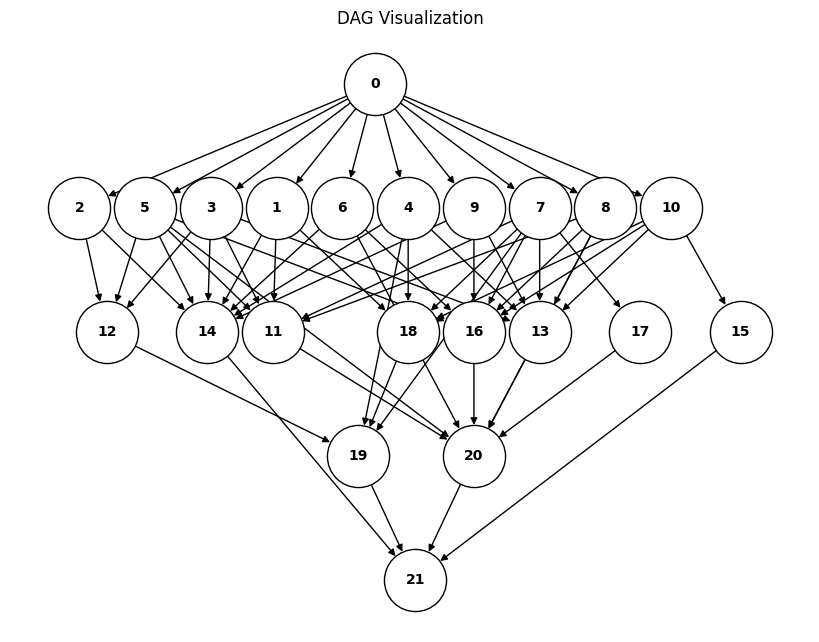

In [118]:
aeft.show_graph()

In [119]:
aeft.run_schedule()

(EFT) Task 0: best pid=0
Scheduling task 0 on processor 0
Task Schedule: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
(IEFT) Task 2: best pid=1
Scheduling task 2 on processor 1
Task Schedule: [1, 3, 4, 5, 6, 7, 8, 9, 10]
(EFT) Task 5: best pid=2
Scheduling task 5 on processor 2
Task Schedule: [1, 3, 4, 6, 7, 8, 9, 10]
(EFT) Task 7: best pid=0
Scheduling task 7 on processor 0
Task Schedule: [1, 3, 4, 6, 8, 9, 10, 17]
(EFT) Task 10: best pid=2
Scheduling task 10 on processor 2
Task Schedule: [1, 3, 4, 6, 8, 9, 17, 15]
(EFT) Task 3: best pid=0
Scheduling task 3 on processor 0
Task Schedule: [1, 4, 6, 8, 9, 17, 15, 12]
(EFT) Task 4: best pid=2
Scheduling task 4 on processor 2
Task Schedule: [1, 6, 8, 9, 17, 15, 12]
(EFT) Task 8: best pid=0
Scheduling task 8 on processor 0
Task Schedule: [1, 6, 9, 17, 15, 12]
(IEFT) Task 6: best pid=0
Scheduling task 6 on processor 0
Task Schedule: [1, 9, 17, 15, 12]
(IEFT) Task 1: best pid=2
Scheduling task 1 on processor 2
Task Schedule: [9, 17, 15, 12, 11, 18]
(IEFT)

In [111]:
print(np.count_nonzero(aeft.graph[5] > -1))

2


In [64]:
test = np.all(aeft.dependency_mx,axis=0)
print(test)
print(np.where(test==True)[0])

[ True  True  True  True  True  True False False False False False False]
[0 1 2 3 4 5]


In [71]:
test = aeft.tasks
for t in test:
    print(aeft.tasks[t].rank)

79.0
62.666666666666664
38.666666666666664
82.33333333333333
87.66666666666667
56.333333333333336
29.0
39.333333333333336
37.666666666666664
27.333333333333332
41.333333333333336
0.0
